# NLP Sentiment Classification with Neural Networks

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import keras
import os
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, SpatialDropout1D, LSTM
from keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from sklearn.metrics import roc_auc_score, roc_curve

In [103]:
num_words = 5000
num_words_to_skip = 50

# Ignore the top n most occurring words; Only use 5000 total words
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=num_words,
                                                        skip_top=num_words_to_skip)
# Load all words for reading reviews
(x_train_all, _), (x_valid_all, _) = imdb.load_data(num_words=None,
                                                    skip_top=0)

In [92]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((25000,), (25000,), (25000,), (25000,))

Each review has been encoded as a sequence of word indexes:

* 0: Padding
* 1: Start char
* 2: Unknown
* 3+: Frequency-encoded index

In [93]:
x_train[0:1]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2])],
      dtype=object)

In [94]:
y_train[0:1]

array([1], dtype=int64)

In [95]:
x_train_all_words = [v for l in x_train for v in l]
print("Number of Unique Words: {}".format(len(np.unique(x_train_all_words))))

Number of Unique Words: 4951


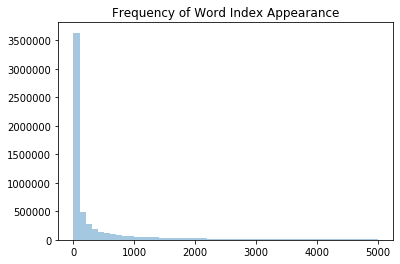

In [96]:
sns.distplot(x_train_all_words, kde=False)
plt.title("Frequency of Word Index Appearance")
plt.show()

As expected, the count of encoded word indexes decreases with the value of the word indexes.

In [97]:
count_words = Counter(x_train_all_words)
sorted_count_words = sorted(count_words.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
sorted_count_words[0:5]

[(2, 3087454), (50, 15735), (51, 15349), (52, 15100), (53, 14246)]

The word index dictionary maps word indexes to their decoded words.

In [98]:
word_index = keras.datasets.imdb.get_word_index()
[(k,v) for i, (k,v) in enumerate(word_index.items()) if i < 10]

[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951),
 ('woods', 1408),
 ('spiders', 16115),
 ('hanging', 2345),
 ('woody', 2289),
 ('trawling', 52008)]

Account for padding, start and unknown chars by shifting word index values by 3. Reverse the dictionary key/value pairs to enable reviews to be parsed.

In [99]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
index_word = {v:k for k,v in word_index.items()}

In [104]:
def parse_review(review):
    print(" ".join([index_word[x] for x in review]))

parse_review(x_train_all[0])

START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

### Preprocessing

The reviews that are fed into a neural network must be the same length.

In [101]:
max_review_length = 100
padding_type = truncating_type = "pre"

x_train_pad = pad_sequences(x_train, maxlen=max_review_length, value=0, padding=padding_type, truncating=truncating_type)
x_valid_pad = pad_sequences(x_valid, maxlen=max_review_length, value=0, padding=padding_type, truncating=truncating_type)

### Baseline Dense

In [105]:
vectorspace_dim = 64
num_dense = 64
dropout = 0.5

model = Sequential()

model.add(Embedding(input_dim=num_words,
                    output_dim=vectorspace_dim,
                    input_length=max_review_length))
model.add(Flatten())
model.add(Dense(num_dense, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [113]:
output_dir = "model_parameters/dense"

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [114]:
batch_size = 128
epochs = 5

# model.fit(x_train_pad, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_valid_pad, y_valid),
#          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 2s 70us/step - loss: 3.4014e-04 - accuracy: 0.9999 - val_loss: 1.1780 - val_accuracy: 0.8159
Epoch 2/5
25000/25000 [==============================] - 1s 56us/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 1.2274 - val_accuracy: 0.8170
Epoch 3/5
25000/25000 [==============================] - 2s 62us/step - loss: 9.7446e-04 - accuracy: 0.9998 - val_loss: 1.2064 - val_accuracy: 0.8183
Epoch 4/5
25000/25000 [==============================] - 2s 60us/step - loss: 1.2693e-04 - accuracy: 1.0000 - val_loss: 1.2795 - val_accuracy: 0.8213
Epoch 5/5
25000/25000 [==============================] - 2s 68us/step - loss: 3.9597e-05 - accuracy: 1.0000 - val_loss: 1.3164 - val_accuracy: 0.8202


The model achieves highest validation accuracy in the 2nd epoch (note: due to random seeding, this may vary from run to run). After that point, it displays signs of overfitting.

Load weights from 2nd epoch:

In [116]:
best_epoch = 2

model.load_weights(output_dir+"/weights.0"+str(best_epoch)+".hdf5")

In [117]:
y_hat = model.predict(x_valid_pad)
y_hat[0:5]

array([[0.20799309],
       [1.        ],
       [0.9998231 ],
       [0.99961245],
       [1.        ]], dtype=float32)

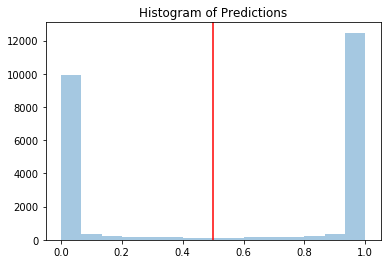

In [123]:
sns.distplot(y_hat, kde=False)
plt.axvline(x=0.5, color="r")
plt.title("Histogram of Predictions")
plt.show()

In [125]:
roc_score = roc_auc_score(y_valid, y_hat)
roc_score

0.9027359455999999

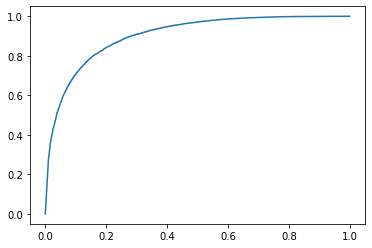

In [137]:
fpr, tpr, thresholds = roc_curve(y_valid, y_hat)
plt.plot(fpr, tpr)
plt.show()

### LSTM

In [146]:
vectorspace_dim = 64
num_lstm = 256
dropout_embed = 0.2
dropout_lstm = 0.2

lstm = Sequential()

lstm.add(Embedding(input_dim=num_words,
                    output_dim=vectorspace_dim,
                    input_length=max_review_length))
lstm.add(SpatialDropout1D(dropout_embed))
lstm.add(LSTM(num_lstm, dropout=dropout_lstm))
lstm.add(Dense(1, activation="sigmoid"))
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 648,961
Trainable params: 648,961
Non-trainable params: 0
_________________________________________________________________


In [147]:
output_dir = "model_parameters/lstm"

lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [148]:
batch_size = 128
epochs = 5

# lstm.fit(x_train_pad, y_train,
#          batch_size=batch_size,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_valid_pad, y_valid),
#          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 71s 3ms/step - loss: 0.5673 - accuracy: 0.6890 - val_loss: 0.3976 - val_accuracy: 0.8309
Epoch 2/5
25000/25000 [==============================] - 72s 3ms/step - loss: 0.3376 - accuracy: 0.8563 - val_loss: 0.3427 - val_accuracy: 0.8508
Epoch 3/5
25000/25000 [==============================] - 75s 3ms/step - loss: 0.2906 - accuracy: 0.8793 - val_loss: 0.3602 - val_accuracy: 0.8481
Epoch 4/5
25000/25000 [==============================] - 82s 3ms/step - loss: 0.2621 - accuracy: 0.8942 - val_loss: 0.3783 - val_accuracy: 0.8440
Epoch 5/5
25000/25000 [==============================] - 80s 3ms/step - loss: 0.2370 - accuracy: 0.9053 - val_loss: 0.3801 - val_accuracy: 0.8419


In [155]:
best_epoch = 2

lstm.load_weights(output_dir+"/weights.0"+str(best_epoch)+".hdf5")

y_hat = lstm.predict(x_valid_pad)

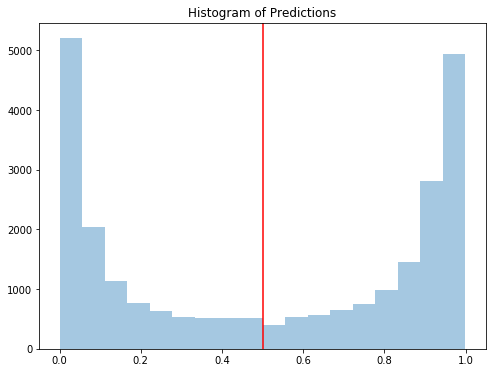

In [154]:
plt.figure(figsize=(8,6))
sns.distplot(y_hat, kde=False)
plt.axvline(x=0.5, color="r")
plt.title("Histogram of Predictions")
plt.show()

In [150]:
roc_score = roc_auc_score(y_valid, y_hat)
roc_score

0.9289419424

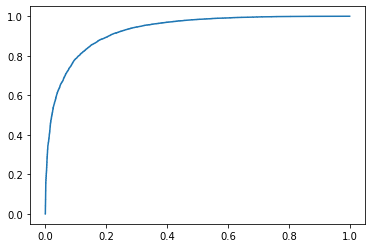

In [151]:
fpr, tpr, thresholds = roc_curve(y_valid, y_hat)
plt.plot(fpr, tpr)
plt.show()